In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
온라인 = pd.read_csv('온라인_전처리_final_32columns.csv')
print(온라인.shape)
온라인.head()

(3196362, 32)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_0,action_type_1,...,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,1,0,...,0,0,0,1,0,1,0,0,1_1,0
1,1,1,NaN,2,23.0,14.0,0,2,1,0,...,0,0,0,1,0,1,0,0,1_1,0
2,1,1,NaN,3,37.0,14.0,0,3,1,0,...,0,0,0,1,0,1,0,0,1_1,0
3,1,2,NaN,1,42.0,15.0,1,1,1,0,...,0,0,0,1,0,1,0,0,1_2,0
4,1,2,NaN,2,57.0,14.0,1,2,1,0,...,0,0,0,1,0,1,0,0,1_2,0


# <br>
## 각 session의 첫번째 구매완료 이전까지 data만 사용

In [3]:
# 고객별 세션당 구매 횟수: 0~25까지 다양함
# 우선 첫번째 구매를 기준으로 자름
온라인.groupby('unique_id').buy.sum().value_counts()

0     319742
1      40869
2       5104
3       1007
4        262
5         86
6         38
7         10
8          6
10         6
9          4
11         4
12         3
17         3
21         2
15         1
18         1
25         1
Name: buy, dtype: int64

In [4]:
# 각 clnt_id별 session이 바뀌는 지점 index 저장
idx1 = 온라인.unique_id.drop_duplicates().index.tolist()
idx2 = idx1[1:] + [len(온라인)]

In [5]:
idx3 = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.buy.iloc[i:j]
    try:
        idx3.append(temp[temp == 1].index[0])
    except:
        idx3.append(j)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [6]:
# (session, sequence, variables) 3d array 변환
온라인_x = []
for i, j in tqdm_notebook(zip(idx1, idx3), total=len(idx1)):
    온라인_x.append(온라인.iloc[i:j, 3:-2].values)
온라인_x = np.array(온라인_x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# session 당 구매 여부
온라인_y = []
for i,j in tqdm_notebook(zip(idx1,idx2), total=len(idx1)):
    온라인_y.append([int(온라인.buy.iloc[i:j].sum()>0)])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# 구매완료한 session이 전체의 약 13%
pd.Series(온라인_y).value_counts()*100/온라인.unique_id.nunique()

[0]    87.087804
[1]    12.912196
dtype: float64

In [13]:
idx = list(pd.Series(idx3) - pd.Series(idx1))
max(idx), np.percentile(pd.Series(idx),99)

(357, 70.0)

In [10]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from keras import backend as K

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0

In [11]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
def make_padding_and_oversample(X, Y):
    max_len = max(idx) #int(np.percentile(pd.Series(idx),99))
    X_padding = sequence.pad_sequences(X, maxlen=max_len, padding='pre', truncating='post')
    X_padding2 = X_padding.reshape(X.shape[0], max_len* X_padding.shape[2])

    smote = SMOTE(random_state=0)
    X_resampled, Y_resampled = smote.fit_resample(X_padding2, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, X_padding.shape[2])
    return X_padding, X_resampled, Y_resampled

In [16]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(온라인_x, 온라인_y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((447638, 357, 27), (191846, 357, 27), (447638,), (191846,))

## LSTM(64)->DENSE(32)->Dropout(0.2)->DENSE(16)->DENSE(1)

In [17]:
def models(train):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(train.shape[1], train.shape[2])))
    model.add(LSTM(64,input_shape = (train.shape[1], train.shape[2])))
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation= 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
    return model

In [18]:
model = models(X_train)
# model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)


Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 477s 1ms/step - loss: 0.2110 - acc: 0.9177 - f1_m: 0.9170 - precision_m: 0.9192 - recall_m: 0.9187 - val_loss: 0.1433 - val_acc: 0.9427 - val_f1_m: 0.9392 - val_precision_m: 0.9989 - val_recall_m: 0.8864
Epoch 2/25
447638/447638 [==============================] - 313s 700us/step - loss: 0.0704 - acc: 0.9743 - f1_m: 0.9741 - precision_m: 0.9802 - recall_m: 0.9690 - val_loss: 0.0472 - val_acc: 0.9825 - val_f1_m: 0.9822 - val_precision_m: 0.9990 - val_recall_m: 0.9660
Epoch 3/25
447638/447638 [==============================] - 257s 574us/step - loss: 0.0506 - acc: 0.9820 - f1_m: 0.9819 - precision_m: 0.9872 - recall_m: 0.9771 - val_loss: 0.0653 - val_acc: 0.9752 - val_f1_m: 0.9746 - val_precision_m: 0.9995 - val_recall_m: 0.9510
Epoch 4/25
447638/447638 [==============================] - 350s 782us/step - loss: 0.0413 - acc: 0.9855 - f1_m: 0.9854 - precision_m: 0.9896 - recall_

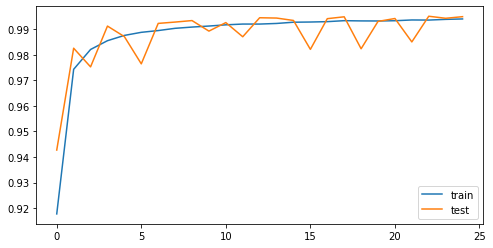

In [20]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [21]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 1196s 6ms/step


In [22]:
accuracy, f1_score, precision, recall

(0.9948760867118835,
 0.9946596622467041,
 0.9978016018867493,
 0.9918892979621887)

## LSTM(64)->DENSE(1)

In [23]:
def models(train):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(train.shape[1], train.shape[2])))
    model.add(LSTM(64,input_shape = (train.shape[1], train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
    return model

In [24]:
model = models(X_train)
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 251s 560us/step - loss: 0.2630 - acc: 0.9074 - f1_m: 0.9073 - precision_m: 0.9151 - recall_m: 0.9034 - val_loss: 0.1281 - val_acc: 0.9683 - val_f1_m: 0.9674 - val_precision_m: 0.9924 - val_recall_m: 0.9437
Epoch 2/25
447638/447638 [==============================] - 245s 547us/step - loss: 0.1127 - acc: 0.9717 - f1_m: 0.9713 - precision_m: 0.9836 - recall_m: 0.9600 - val_loss: 0.0921 - val_acc: 0.9794 - val_f1_m: 0.9796 - val_precision_m: 0.9721 - val_recall_m: 0.9871
Epoch 3/25
447638/447638 [==============================] - 244s 545us/step - loss: 0.0798 - acc: 0.9818 - f1_m: 0.9816 - precision_m: 0.9890 - recall_m: 0.9747 - val_loss: 0.0625 - val_acc: 0.9884 - val_f1_m: 0.9884 - val_precision_m: 0.9909 - val_recall_m: 0.9859
Epoch 4/25
447638/447638 [==============================] - 244s 546us/step - loss: 0.0630 - acc: 0.9853 - f1_m: 0.9852 - precision_m: 0.9907 - recall

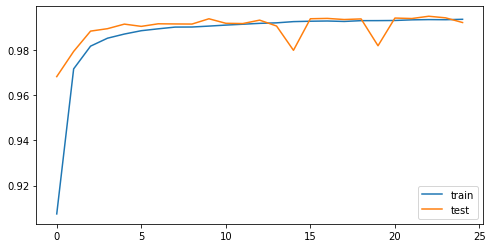

In [25]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [26]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)
accuracy, f1_score, precision, recall

191846/191846 [==============================] - 1180s 6ms/step


(0.9922385811805725, 0.9918496012687683, 0.99876868724823, 0.9855744242668152)

# <br>
# Appendix
# 참고만하세요

### 구매완료 이전의 hit_seq를 버림
### 각 sequence length의 0.25-0.75배 random값

In [85]:
import random
remove_ratio = pd.Series([random.random() for i in range(len(온라인_x))]) + 0.5
seq_length = pd.Series(온라인_x).map(lambda x: len(x))
remove_seq_length = np.floor(remove_ratio*seq_length)/2 # 각 session에서 버릴 seq 개수

In [86]:
온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))

In [87]:
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
np.percentile(seq_length2, 99)

38.0

In [88]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y, length=38)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(447638, 38, 20)

In [99]:
model = models(X_train)
# model.summary()

In [100]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 28s 63us/step - loss: 0.3614 - acc: 0.8446 - f1_m: 0.8367 - precision_m: 0.8765 - recall_m: 0.8062 - val_loss: 0.2746 - val_acc: 0.8738 - val_f1_m: 0.8644 - val_precision_m: 0.9327 - val_recall_m: 0.8058
Epoch 2/25
447638/447638 [==============================] - 27s 61us/step - loss: 0.2692 - acc: 0.8800 - f1_m: 0.8760 - precision_m: 0.9059 - recall_m: 0.8512 - val_loss: 0.2492 - val_acc: 0.8866 - val_f1_m: 0.8813 - val_precision_m: 0.9237 - val_recall_m: 0.8429
Epoch 3/25
447638/447638 [==============================] - 27s 61us/step - loss: 0.2544 - acc: 0.8860 - f1_m: 0.8828 - precision_m: 0.9085 - recall_m: 0.8608 - val_loss: 0.2432 - val_acc: 0.8890 - val_f1_m: 0.8835 - val_precision_m: 0.9281 - val_recall_m: 0.8432
Epoch 4/25
447638/447638 [==============================] - 27s 61us/step - loss: 0.2472 - acc: 0.8889 - f1_m: 0.8860 - precision_m: 0.9093 - recall_m: 0.86

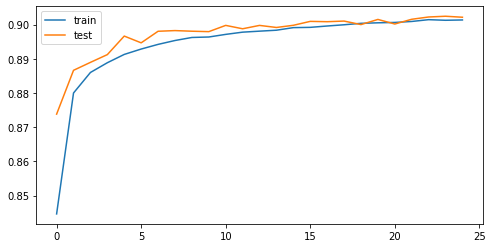

In [101]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [102]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 137s 716us/step


In [103]:
print(accuracy)

0.9021663069725037


### 각 sequence length의 0.5-0.75배 random값

In [104]:
remove_ratio = pd.Series([random.random() for i in range(len(온라인_x))]) + 2
remove_seq_length = np.floor(remove_ratio*seq_length)/4

온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
np.percentile(seq_length2,99)

27.0

In [112]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y, length=27)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: 

In [106]:
model = models(X_train)
# model.summary()
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 21s 46us/step - loss: 0.3714 - acc: 0.8374 - f1_m: 0.8298 - precision_m: 0.8703 - recall_m: 0.7997 - val_loss: 0.2945 - val_acc: 0.8665 - val_f1_m: 0.8565 - val_precision_m: 0.9244 - val_recall_m: 0.7982
Epoch 2/25
447638/447638 [==============================] - 20s 45us/step - loss: 0.2897 - acc: 0.8670 - f1_m: 0.8632 - precision_m: 0.8900 - recall_m: 0.8415 - val_loss: 0.2683 - val_acc: 0.8772 - val_f1_m: 0.8720 - val_precision_m: 0.9094 - val_recall_m: 0.8379
Epoch 3/25
447638/447638 [==============================] - 20s 45us/step - loss: 0.2761 - acc: 0.8730 - f1_m: 0.8697 - precision_m: 0.8935 - recall_m: 0.8498 - val_loss: 0.2933 - val_acc: 0.8687 - val_f1_m: 0.8583 - val_precision_m: 0.9306 - val_recall_m: 0.7967
Epoch 4/25
447638/447638 [==============================] - 20s 45us/step - loss: 0.2693 - acc: 0.8762 - f1_m: 0.8731 - precision_m: 0.8964 - recall_m: 0.85

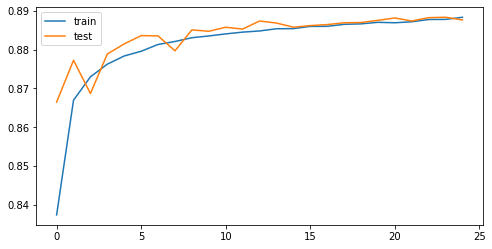

In [107]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [109]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 103s 534us/step


In [110]:
print(accuracy)

0.8876338601112366


### 각 sequence length의 0.5배 값

In [111]:
remove_seq_length = np.floor(0.5*seq_length)
온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
np.percentile(seq_length2,99)

35.0

In [113]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y, length=35)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
X_train.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(447638, 35, 20)

In [114]:
model = models(X_train)
# model.summary()
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 26s 58us/step - loss: 0.3562 - acc: 0.8479 - f1_m: 0.8409 - precision_m: 0.8770 - recall_m: 0.8136 - val_loss: 0.2657 - val_acc: 0.8838 - val_f1_m: 0.8815 - val_precision_m: 0.8979 - val_recall_m: 0.8659
Epoch 2/25
447638/447638 [==============================] - 25s 57us/step - loss: 0.2646 - acc: 0.8807 - f1_m: 0.8780 - precision_m: 0.8993 - recall_m: 0.8607 - val_loss: 0.2513 - val_acc: 0.8841 - val_f1_m: 0.8793 - val_precision_m: 0.9160 - val_recall_m: 0.8456
Epoch 3/25
447638/447638 [==============================] - 25s 56us/step - loss: 0.2518 - acc: 0.8855 - f1_m: 0.8832 - precision_m: 0.9020 - recall_m: 0.8672 - val_loss: 0.2419 - val_acc: 0.8892 - val_f1_m: 0.8867 - val_precision_m: 0.9065 - val_recall_m: 0.8679
Epoch 4/25
447638/447638 [==============================] - 25s 56us/step - loss: 0.2451 - acc: 0.8883 - f1_m: 0.8862 - precision_m: 0.9029 - recall_m: 0.87

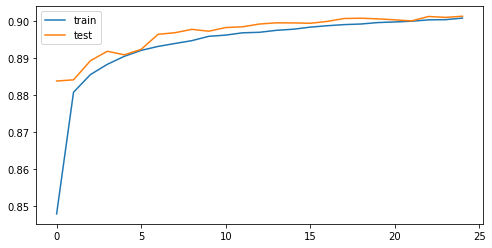

In [115]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [116]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 129s 673us/step


In [117]:
print(accuracy)

0.9012280702590942


In [122]:
a_features

35

In [123]:
len(full_X_c)

20

In [121]:
## Sensitivity Analysis
full_X_c = 온라인.iloc[:,5:-2].columns
a_features = int(X_train.shape[1])
importance_df = pd.DataFrame(np.zeros((a_features, 2)), 
                             columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(a_features):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size= new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = full_X_c[i]
        importance_df.iloc[i,1] = effect
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')

var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

Variable 1, perturbation effect: 0.0254
Variable 2, perturbation effect: 0.0938
Variable 3, perturbation effect: 0.0795
Variable 4, perturbation effect: 0.0574
Variable 5, perturbation effect: 0.0626
Variable 6, perturbation effect: 0.0730
Variable 7, perturbation effect: 0.0102
Variable 8, perturbation effect: 0.0371
Variable 9, perturbation effect: 0.1393
Variable 10, perturbation effect: 0.0383
Variable 11, perturbation effect: 0.0397
Variable 12, perturbation effect: 0.0227
Variable 13, perturbation effect: 0.0090
Variable 14, perturbation effect: 0.0082
Variable 15, perturbation effect: 0.0140
Variable 16, perturbation effect: 0.0129
Variable 17, perturbation effect: 0.0762
Variable 18, perturbation effect: 0.0508
Variable 19, perturbation effect: 0.0500
Variable 20, perturbation effect: 0.0671


IndexError: index 20 is out of bounds for axis 2 with size 20

In [124]:
importance_df

,varible_name,perturbation_effect
0,hit_stay_tm,0.025381
1,action_type_1,0.093816
2,action_type_2,0.079513
3,action_type_3,0.057379
4,action_type_4,0.062568
5,action_type_5,0.073003
6,action_type_7,0.010199
7,biz_unit_A02,0.037097
8,biz_unit_A03,0.139290
9,sess_dt_201908,0.038270


In [ ]:
## Plot 예시
mpl.rc('font', family='New Gulim')
mpl.rc('axes', unicode_minus=False)
plt.subplots(figsize=(18,5))
plt.bar(importance_df.iloc[:,0], importance_df.iloc[:,1])
plt.title('Sensitivity Analysis')
plt.xlabel('IV')
plt.ylabel('Perturbation Effect')
plt.xticks(importance_df.iloc[:,0], rotation=90)
plt.show()

## Conv1D + LSTM

In [163]:
model = Sequential()
#model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 31, 64)            5184      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 64)             20544     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 38,689
Trainable params: 38,689
Non-trainable params: 0
________________________________________________

In [164]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 11s 25us/step - loss: 0.5746 - acc: 0.7051 - val_loss: 0.5174 - val_acc: 0.7453
Epoch 2/25
447638/447638 [==============================] - 8s 19us/step - loss: 0.5042 - acc: 0.7525 - val_loss: 0.4900 - val_acc: 0.7592
Epoch 3/25
447638/447638 [==============================] - 8s 19us/step - loss: 0.4832 - acc: 0.7633 - val_loss: 0.4798 - val_acc: 0.7631
Epoch 4/25
447638/447638 [==============================] - 8s 19us/step - loss: 0.4719 - acc: 0.7693 - val_loss: 0.4981 - val_acc: 0.7510
Epoch 5/25
447638/447638 [==============================] - 8s 19us/step - loss: 0.4638 - acc: 0.7728 - val_loss: 0.4628 - val_acc: 0.7717
Epoch 6/25
447638/447638 [==============================] - 8s 19us/step - loss: 0.4583 - acc: 0.7751 - val_loss: 0.4578 - val_acc: 0.7754
Epoch 7/25
447638/447638 [==============================] - 8s 19us/step - loss: 0.4545 - acc: 0.7769 - val_loss:

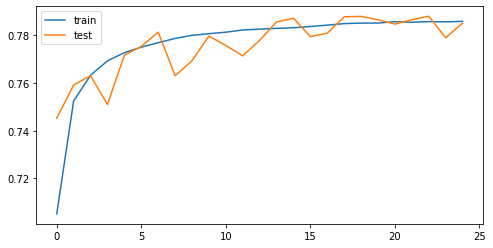

In [165]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [166]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 30s 155us/step


In [167]:
print(accuracy)

0.7851036787033081


In [168]:
model = Sequential()
#model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(128, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(32))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 31, 128)           10368     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 6, 64)             41024     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)              

In [169]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 10s 22us/step - loss: 0.5590 - acc: 0.7162 - val_loss: 0.5211 - val_acc: 0.7448
Epoch 2/25
447638/447638 [==============================] - 9s 20us/step - loss: 0.4948 - acc: 0.7562 - val_loss: 0.4795 - val_acc: 0.7612
Epoch 3/25
447638/447638 [==============================] - 9s 20us/step - loss: 0.4752 - acc: 0.7674 - val_loss: 0.5094 - val_acc: 0.7365
Epoch 4/25
447638/447638 [==============================] - 9s 20us/step - loss: 0.4630 - acc: 0.7730 - val_loss: 0.4793 - val_acc: 0.7585
Epoch 5/25
447638/447638 [==============================] - 9s 20us/step - loss: 0.4565 - acc: 0.7766 - val_loss: 0.4527 - val_acc: 0.7780
Epoch 6/25
447638/447638 [==============================] - 9s 20us/step - loss: 0.4511 - acc: 0.7789 - val_loss: 0.4800 - val_acc: 0.7564
Epoch 7/25
447638/447638 [==============================] - 9s 20us/step - loss: 0.4471 - acc: 0.7804 - val_loss:

In [171]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 29s 153us/step


In [172]:
print(accuracy)

0.7881842851638794
